# MODELO 1 - CGAN para generar un dígito del mnist a pedido del usuario

- Importo las librerias neceasarias

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, Embedding, Concatenate
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
noise_dim = 100
n_class = 10

tags = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_size = X_train.shape[1] # tamaño de las imagenes

X_train = np.reshape(X_train, [-1, img_size, img_size, 1])
X_train = np.repeat(X_train, 3, axis=-1)  # Convertir a 3 canales

# Normalize the data
X_train = (X_train - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]

y_train = np.expand_dims(y_train, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 3)
(60000, 1)
(10000, 28, 28)
(10000,)


- Ploteo de un número random del dataset junto con su etiqueta

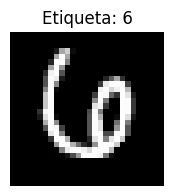

In [3]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"Etiqueta: {tags[y_train[idx][0]]}")
plt.show()

# Construcción del generador

In [4]:
def build_generator():
    # label input
    in_label = Input(shape=(1,), name='Label_Input')
    # create an embedding layer for all the 10 classes in the form of a vector of size 50 (ver paper)
    li = Embedding(n_class, 50, name='Embedding')(in_label)
 
    n_nodes = 7 * 7
    li = Dense(n_nodes, name='Label_Dense')(li)
    # reshape the layer
    li = Reshape((7, 7, 1), name='Label_Reshape')(li)
 
    # image generator input
    in_lat = Input(shape=(noise_dim,), name='Latent_Input')
 
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat)
    gen = LeakyReLU(negative_slope=0.2, name='Generator_LeakyReLU_1')(gen)
    gen = Reshape((7, 7, 128), name='Generator_Reshape')(gen)
 
    # merge image gen and label input
    merge = Concatenate(name='Concatenate')([gen, li])
 
    gen = Conv2DTranspose(
        128, (4, 4), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 14x14x128
    gen = LeakyReLU(negative_slope=0.2, name='Generator_LeakyReLU_2')(gen)
 
    gen = Conv2DTranspose(
        128, (4, 4), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 28x28x128
    gen = LeakyReLU(negative_slope=0.2, name='Generator_LeakyReLU_3')(gen)
 
    out_layer = Conv2D(
        3, (8, 8), activation='tanh', padding='same', name='Output_Conv2D')(gen)  # 28x28x3 #acá lo lleva a 32x32x3 porque es el tamaño de las imagenes del mnist 
 
    generator = Model([in_lat, in_label], out_layer, name='Generator')

    # Después, puedes usar plot_model para crear una imagen del modelo
    plot_model(generator, to_file='generator_structure.png', show_shapes=True, show_layer_names=True)

    return generator

In [5]:
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5) # Defino el optimizador
g_model = build_generator()
g_model.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Latent_Input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label_Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator_Dense     │ (None, 6272)      │    633,472 │ Latent_Input[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 1, 50)     │        500 │ Label_Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator_LeakyReL… │ (None, 6272)      │          0 │ Generator_Dense[… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label_Dense (Dense) │ (None, 1, 49)     │      2,499 │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator_Reshape   │ (None, 7, 7, 128) │          0 │ Generator_LeakyR… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label_Reshape       │ (None, 7, 7, 1)   │          0 │ Label_Dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate         │ (None, 7, 7, 129) │          0 │ Generator_Reshap… │
│ (Concatenate)       │                   │            │ Label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2DTranspose_1   │ (None, 14, 14,    │    264,320 │ Concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator_LeakyReL… │ (None, 14, 14,    │          0 │ Conv2DTranspose_… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2DTranspose_2   │ (None, 28, 28,    │    262,272 │ Generator_LeakyR… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Generator_LeakyReL… │ (None, 28, 28,    │          0 │ Conv2DTranspose_… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Conv2D       │ (None, 28, 28, 3) │     24,579 │ Generator_LeakyR… │
│ (Conv2D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,187,642 (4.53 MB)

 Trainable params: 1,187,642 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

# Construcción del discriminador

In [6]:
def build_discriminator():
    
    # label input
    in_label = Input(shape=(1,), name='Label_Input')
    # This vector of size 50 will be learnt by the discriminator (ver paper)
    li = Embedding(n_class, 50, name='Embedding')(in_label)
   
    n_nodes = img_size * img_size 
    li = Dense(n_nodes, name='Label_Dense')(li) 
  
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li) 
  
    # image input
    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input') 
   
    merge = Concatenate(name='Concatenate')([in_image, li]) 
 
    # We will combine input label with input image and supply as inputs to the model. 
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='Conv2D_1')(merge) 
    fe = LeakyReLU(negative_slope=0.2, name='LeakyReLU_1')(fe)
   
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='Conv2D_2')(fe) 
    fe = LeakyReLU(negative_slope=0.2, name='LeakyReLU_2')(fe)
   
    fe = Flatten(name='Flatten')(fe) 
   
    fe = Dropout(0.4, name='Dropout')(fe)
   
    out_layer = Dense(1, activation='sigmoid', name='Output')(fe)
 
    # Define model the model. 
    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    
       
    # Después, puedes usar plot_model para crear una imagen del modelo
    plot_model(discriminator, to_file='discriminator_structure.png', show_shapes=True, show_layer_names=True)

    return discriminator

In [7]:
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5) # Defino el optimizador
d_model = build_discriminator()
d_model.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Label_Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 1, 50)     │        500 │ Label_Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label_Dense (Dense) │ (None, 1, 784)    │     39,984 │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Input         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label_Reshape       │ (None, 28, 28, 1) │          0 │ Label_Dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate         │ (None, 28, 28, 4) │          0 │ Image_Input[0][0… │
│ (Concatenate)       │                   │            │ Label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_1 (Conv2D)   │ (None, 14, 14,    │      4,736 │ Concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LeakyReLU_1         │ (None, 14, 14,    │          0 │ Conv2D_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_2 (Conv2D)   │ (None, 7, 7, 128) │    147,584 │ LeakyReLU_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LeakyReLU_2         │ (None, 7, 7, 128) │          0 │ Conv2D_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 6272)      │          0 │ LeakyReLU_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout (Dropout)   │ (None, 6272)      │          0 │ Flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │      6,273 │ Dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 199,077 (777.64 KB)

 Trainable params: 199,077 (777.64 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Helper function to plot generated images
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(10,num_samples, figsize=(10,20)) 
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)
 
    for l in np.arange(10):
      random_noise = tf.random.normal(shape=(num_samples, noise_dim))
      label = tf.ones(num_samples)*l
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])
 
        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

# Definición de las funciones de pérdida (loss)

In [9]:
# Define Loss function for Classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()
 
# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss
   
# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [10]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, accuracy

# Paso de entrenamiento por batches 

In [11]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size):

    real_images, real_labels = image_batch 
    # Sample random points in the latent space and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
    generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas
 
    # Train the discriminator.
    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales
         
        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
    
    
    all_real_labels = [] # Guardo las etiquetas reales
    all_pred_labels = []  # Guardo las etiquetas predichas
    
    # Extender las listas con las etiquetas correspondientes
    for i in range(batch_size):
        all_real_labels.append(1)  # Etiqueta real para imágenes reales
        all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
    for i in range(batch_size):
        all_real_labels.append(0)  # Etiqueta real para imágenes falsas
        all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas
            
       
    grads = tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador
 
    #-----------------------------------------------------------------#
     
    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
    
    # Train the generator
    with tf.GradientTape() as tape: 
        fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
        predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        g_loss = generator_loss(predictions) # Calculo la loss del generador
     
    grads = tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [12]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size):

    real_images, real_labels = image_batch 
    # Sample random points in the latent space and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
    generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

    pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
    pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales
        
    d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
    
    all_real_labels = [] # Guardo las etiquetas reales
    all_pred_labels = []  # Guardo las etiquetas predichas
    
    # Extender las listas con las etiquetas correspondientes
    for i in range(batch_size):
        all_real_labels.append(1)  # Etiqueta real para imágenes reales
        all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
    for i in range(batch_size):
        all_real_labels.append(0)  # Etiqueta real para imágenes falsas
        all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    #-----------------------------------------------------------------#
     
    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
    
    fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
    predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
    g_loss = generator_loss(predictions) # Calculo la loss del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [13]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    d_loss_list_epoch_train = []
    g_loss_list_epoch_train = []
    d_loss_list_epoch_test = []
    g_loss_list_epoch_test = []
    precision_list_train = []
    recall_list_train = []
    f1_list_train = []
    accuracy_list_train = []
    precision_list_test = []
    recall_list_test = []
    f1_list_test = []
    accuracy_list_test = []

 
    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)
        d_loss_list_batch_train = []
        g_loss_list_batch_train = []
        d_loss_list_batch_test = []
        g_loss_list_batch_test = []

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Número de batche: "): # Itero sobre todos los batches
            
            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size) # Entreno el modelo

            d_loss_list_batch_train.append(d_loss_train) # Guardo la loss del discriminador
            g_loss_list_batch_train.append(g_loss_train) # Guardo la loss del generador
            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,))
            
            #print("all_pred_labels: ", all_pred_labels)
            #print("all_real_labels: ", all_real_labels)
            # print("Tipo de all_real_labels:", type(all_real_labels))
            # print("Tipo de all_pred_labels_flat:", type(all_pred_labels))
            # print("Tipo de all_real_labels:", all_real_labels.shape)
            # print("Tipo de all_pred_labels_flat:", all_pred_labels.shape)
            #print("Tipo de all_pred_labels_flat:", type(all_pred_labels))

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_train.append(precision_train)
            recall_list_train.append(recall_train)
            f1_list_train.append(f1_train)
            accuracy_list_train.append(accuracy_train)

            itern=itern+1 

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Número de batche: "): # Itero sobre todos los batches
            
            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size) # Entreno el modelo
            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))
            #print("all_pred_labels_test: ", all_pred_labels_test)
            #print("all_real_labels_test: ", all_real_labels_test)
            # print("Tipo de all_real_labels:", type(all_real_labels))
            # print("Tipo de all_pred_labels_flat:", type(all_pred_labels))
            # print("Tipo de all_real_labels:", all_real_labels.shape)
            # print("Tipo de all_pred_labels_flat:", all_pred_labels.shape)
            #print("Tipo de all_pred_labels_flat:", type(all_pred_labels_test))

            d_loss_list_batch_test.append(d_loss_test) # Guardo la loss del discriminador
            g_loss_list_batch_test.append(g_loss_test) # Guardo la loss del generador

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_test.append(precision_test)
            recall_list_test.append(recall_test)
            f1_list_test.append(f1_test)
            accuracy_list_test.append(accuracy_test)

            itern=itern+1 
        
        d_loss_list_epoch_train.append(np.mean(d_loss_list_batch_train))
        g_loss_list_epoch_train.append(np.mean(g_loss_list_batch_train))
        d_loss_list_epoch_test.append(np.mean(d_loss_list_batch_test))
        g_loss_list_epoch_test.append(np.mean(g_loss_list_batch_test))
        
        
        if epoch % 100 == 0:
            print (f'Epoch: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train)}, Discriminator Loss: {np.mean(d_loss_list_batch_train)}\n')
            print (f'Took {time.time()-start} seconds. \n\n')
        if epoch % 500 == 0:
            show_samples(5, n_class, g_model)

    return d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_train, recall_list_train, f1_list_train, accuracy_list_train, precision_list_test, recall_list_test, f1_list_test, accuracy_list_test 

# Entrenamiento de la CGAN

In [14]:
epoch_count = 1 #100 # Cantidad de epocas 
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches

# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_train, recall_list_train, f1_list_train, accuracy_list_train, precision_list_test, recall_list_test, f1_list_test, accuracy_list_test  = train(train_dataset, test_dataset, epoch_count, batch_size)

g_model.save("gmodel_mnist_v1.keras")
d_model.save("dmodel_mnist_v1.keras")

Epoch:  1


Número de batche:  55%|█████▍    | 2058/3750 [01:50<01:45, 16.04it/s]

# Funciones de loss para el generador y el discriminador

In [ ]:
plt.figure(figsize=(8,6))
epochs = np.arange(1, epoch_count+1)
plt.plot(epochs, g_loss_list_epoch_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_list_epoch_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_list_epoch_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_list_epoch_test, label='Discriminator Loss - test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generación de un dígito pedido por el usuario

In [ ]:
# Cargar el modelo generador
g_model = load_model('gmodel_mnist_v1.keras')

# Preparar la etiqueta para el número 7
numero_a_generar = 7

label = np.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10

# Generar ruido aleatorio
noise = np.random.normal(size=(1, noise_dim))

# Generar imagen falsa 
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])

plt.figure(figsize=(2,2))
print(generated_image.shape)
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{numero_a_generar}")
plt.show()